In [1]:
import pandas as pd
# set the environment path to find Recommenders
import sys
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Spark version: 3.2.1


In [2]:
import findspark

findspark.init()

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
COL_USER = "UserId"
COL_ITEM = "ProductId"
COL_RATING = "Rating"
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
    )
)


In [32]:
# Well I'm not sure if this is the best way, but there are so few above 5 I think I can group them all together
rec_data = pd.read_csv('rec_df.csv')
rec_data['rating'] = rec_data['count'].apply(lambda x: 5 if (x >= 5) else x)
new_rec_data = rec_data.drop(columns='count')
new_rec_data =  new_rec_data.drop(columns='Unnamed: 0')

In [6]:
new_rec_data.to_csv('rec_df_new.csv')

In [40]:
rec_data = pd.read_csv('rec_df_new.csv')

In [41]:
rec_data.head()

,user_id,product_id,rating
0,1,196,5
1,1,12427,5
2,1,10258,5
3,1,25133,5
4,1,13032,4


In [43]:
rec_data = rec_data.reset_index(drop=True)

In [36]:
new_rec_data = new_rec_data[['user_id', 'product_id', 'rating']]

In [44]:
rec_data

,user_id,product_id,rating
0,1,196,5
1,1,12427,5
2,1,10258,5
3,1,25133,5
4,1,13032,4
...,...,...,...
1048570,15759,22170,3
1048571,15759,45066,3
1048572,15759,28842,3
1048573,15759,24622,3


In [5]:
df = spark.read.option("header",True).csv("rec_df_new.csv", schema=schema)
df.printSchema()

root
 |-- UserId: integer (nullable = true)
 |-- ProductId: integer (nullable = true)
 |-- Rating: float (nullable = true)



In [6]:
df.show()

+------+---------+------+
|UserId|ProductId|Rating|
+------+---------+------+
|     1|      196|   5.0|
|     1|    12427|   5.0|
|     1|    10258|   5.0|
|     1|    25133|   5.0|
|     1|    13032|   4.0|
|     1|    46149|   4.0|
|     1|    26405|   3.0|
|     1|    26088|   3.0|
|     1|    49235|   3.0|
|     1|    13176|   2.0|
|     1|    38928|   2.0|
|     1|    39657|   2.0|
|     1|    14084|   1.0|
|     1|    30450|   1.0|
|     1|    41787|   1.0|
|     1|    17122|   1.0|
|     1|    10326|   1.0|
|     1|    35951|   1.0|
|     1|    27845|   1.0|
|     2|    32792|   5.0|
+------+---------+------+
only showing top 20 rows



In [7]:
train, test = spark_random_split(df, ratio=0.75, seed=234)
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 786908
N test 261667


In [8]:
train.printSchema()

root
 |-- UserId: integer (nullable = true)
 |-- ProductId: integer (nullable = true)
 |-- Rating: float (nullable = true)



In [9]:
train[0]

Column<'UserId'>

In [10]:
train.show()

+------+---------+------+
|UserId|ProductId|Rating|
+------+---------+------+
|     1|      196|   5.0|
|     1|    10258|   5.0|
|     1|    10326|   1.0|
|     1|    13032|   4.0|
|     1|    14084|   1.0|
|     1|    17122|   1.0|
|     1|    25133|   5.0|
|     1|    26405|   3.0|
|     1|    27845|   1.0|
|     1|    30450|   1.0|
|     1|    35951|   1.0|
|     1|    39657|   2.0|
|     1|    41787|   1.0|
|     1|    46149|   4.0|
|     1|    49235|   3.0|
|     2|     1559|   5.0|
|     2|     1757|   1.0|
|     2|     2002|   4.0|
|     2|     2361|   1.0|
|     2|     2573|   2.0|
+------+---------+------+
only showing top 20 rows



In [15]:
regparam = [0.001,0.01,0.1,1,10]
w_item =  [2.0,4.0,6.0,8.0,10.0]

In [16]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
mse = []
combinations = []
for i in w_item:
    for p in regparam:  
        new_als_algo = ALS(rank=i,maxIter=15,implicitPrefs=False,regParam=p,coldStartStrategy='drop',nonnegative=False,seed=42,**header)
        model= new_als_algo.fit(train)
        print("Training Done")
        combinations.append([i,p])
        df_pred_test =  model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",
                                predictionCol="prediction")
        rmse = evaluator.evaluate(df_pred_test)
        mse.append(rmse)
        print("regparam:", p , " w_item :", i ,"RMSE: ", mse)
print("Best parameters using Grid Search CV",  combinations[mse.index(min(mse))])

Training Done
regparam: 0.001  w_item : 2.0 RMSE:  [1.9129356095205834]
Training Done
regparam: 0.01  w_item : 2.0 RMSE:  [1.9129356095205834, 1.3765306705713083]
Training Done
regparam: 0.1  w_item : 2.0 RMSE:  [1.9129356095205834, 1.3765306705713083, 1.2825211255323097]
Training Done
regparam: 1  w_item : 2.0 RMSE:  [1.9129356095205834, 1.3765306705713083, 1.2825211255323097, 1.5850989896082424]
Training Done
regparam: 10  w_item : 2.0 RMSE:  [1.9129356095205834, 1.3765306705713083, 1.2825211255323097, 1.5850989896082424, 2.3571178210944055]
Training Done
regparam: 0.001  w_item : 4.0 RMSE:  [1.9129356095205834, 1.3765306705713083, 1.2825211255323097, 1.5850989896082424, 2.3571178210944055, 1.8412382861649843]
Training Done
regparam: 0.01  w_item : 4.0 RMSE:  [1.9129356095205834, 1.3765306705713083, 1.2825211255323097, 1.5850989896082424, 2.3571178210944055, 1.8412382861649843, 1.4817918900934426]
Training Done
regparam: 0.1  w_item : 4.0 RMSE:  [1.9129356095205834, 1.376530670571308

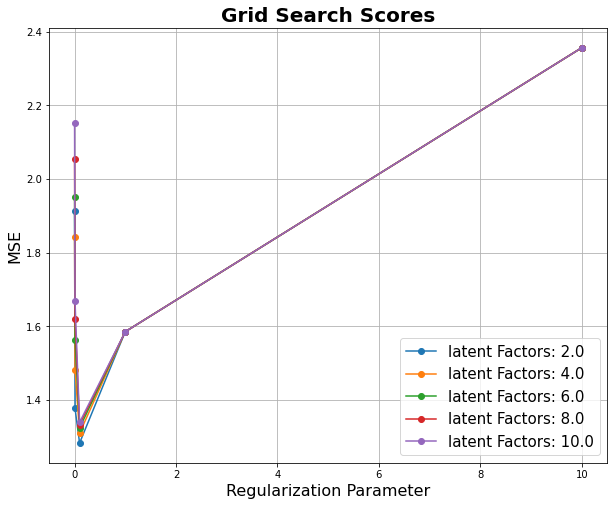

In [30]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    
    plt.figure(figsize=(10,8))
    # Plot Grid search scores
   # _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        plt.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
     
    plt.title("Grid Search Scores", fontsize=20, fontweight='bold')
    plt.xlabel(name_param_1, fontsize=16)
    plt.ylabel('MSE', fontsize=16)
    plt.legend(loc="best", fontsize=15)
    plt.grid('on')

# Calling Method 
plot_grid_search(mse, regparam, w_item, 'Regularization Parameter', 'latent Factors')


In [31]:
print("Best parameters using Grid Search CV",  combinations[mse.index(min(mse))], min(mse))

Best parameters using Grid Search CV [2.0, 0.1] 1.2825211255323097


In [32]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}


als = ALS(
    rank=2,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.1,
    
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [33]:
model = als.fit(train)

In [34]:
df_pred_test =  model.transform(test)

In [35]:
df_pred_test.show()

+------+---------+------+----------+
|UserId|ProductId|Rating|prediction|
+------+---------+------+----------+
|   471|     8638|   2.0| 1.3484831|
|  1238|     8638|   1.0| 1.9554391|
|  2999|    14450|   2.0| 1.3217186|
|  2999|    46266|   1.0| 2.3774297|
|  3475|    28836|   1.0|  2.164081|
|  3475|    29894|   1.0| 1.1991086|
|  1139|    44596|   1.0| 1.3471663|
|  2748|    17679|   1.0| 1.7038741|
|  2249|     9427|   1.0| 0.2503165|
|  4383|    29814|   1.0| 1.1621917|
|  4357|    31912|   1.0| 1.3476986|
|  1787|    29894|   1.0|0.99046844|
|  3242|    44596|   2.0| 1.5246205|
|  2396|    34234|   3.0| 2.4457977|
|   375|    31912|   5.0|  2.243393|
|  3844|    31912|   1.0| 1.1632549|
|   796|    28170|   1.0|  5.144572|
|  4321|    31912|   5.0| 1.8940439|
|  2771|    14450|   1.0| 0.9188187|
|  1869|    29894|   1.0|0.67721546|
+------+---------+------+----------+
only showing top 20 rows



In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(df_pred_test)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.2825211255323097
